# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [1]:
from tqdm import tqdm

In [2]:
# all import statements needed for the project, for example:

import math
from math import radians, sin, cos, asin, sqrt

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import requests
import sqlalchemy as db
import re
import numpy as np

from datetime import datetime

In [3]:
# any general notebook setup, like log formatting
import warnings
# setting ignore as a parameter
warnings.filterwarnings('ignore') 

In [88]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library.
* [ ] Taxi data:
    * [ ] Use the `re` module, and the packages `requests`, BeautifulSoup (`bs4`), and (optionally) `pandas` to programmatically download the required CSV files & load into memory.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* [ ] Weather & Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
* [ ] All data:
    * [ ] Load the data using `pandas`
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * (Taxi & Uber data) Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] (Taxi data) Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* [ ] Weather data:
    * [ ] Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
    * [ ] You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 

### Calculating distance
_**TODO:** Write some prose that tells the reader what you're about to do here._

In [5]:
def calculate_distance(from_coord, to_coord):
    # calculate the dstance between two coordinates in kilometers
    
    # get the statistics from the imported file 
    pickup_longitude = from_coord['pickup_longitude'].map(radians)
    pickup_latitude = from_coord['pickup_latitude'].map(radians)
    dropoff_longitude = to_coord['dropoff_longitude'].map(radians)
    dropoff_latitude = to_coord['dropoff_latitude'].map(radians)
    
  
    Radius_of_earth = 6378.1
    diff_lon = pickup_longitude - dropoff_longitude
    diff_lat = pickup_latitude - dropoff_latitude
    
    # calculate the result using following equations
    part_one = (diff_lat/2).map(sin)**2 + pickup_latitude.map(cos)*dropoff_latitude.map(cos)* (diff_lon/2).map(sin)**2
    part_two =  part_one.map(sqrt).map(asin)
    
    dist = 2*part_two*Radius_of_earth
    
    return dist

In [6]:
def add_distance_column(dataframe):
    # using the distance calculating function above to get a new column for the original dataframe
    from_coord = dataframe[['pickup_latitude', 'pickup_longitude']]
    to_coord = dataframe[['dropoff_latitude', 'dropoff_longitude']]
    dataframe['distance'] = calculate_distance(from_coord, to_coord)
    return dataframe

### Processing Taxi Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [7]:
def find_taxi_csv_urls():
    # get all the URLs meet the requirements from the given website.
    
    # input the known website
    TAXI_URL = "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

    # get the links meet the requirements(for yellow taxi from 2009-01 to 2015-06)
    response = requests.get(TAXI_URL)
    html = response.content
    soup = bs4.BeautifulSoup(html, "html.parser")
    
    # derive all yellow taxi files
    yellow_taxi = soup.find_all("a", attrs={"title": "Yellow Taxi Trip Records"})
    all_links = [a["href"] for a in yellow_taxi]

    # derive 2009-01 to 2015-06 records for yellow taxi
    pattern = re.compile(
    r"yellow_tripdata_2009-([0-9]{2})|yellow_tripdata_201([0-4])-([0-9]{2})|yellow_tripdata_2015-0([1-6]).parquet"
    )
    
    # create a empty list in order to store the links
    URLs = []

    # using for loop to see whether the URLs match the pattern
    # and add to the list created before if the pattern is matched
    for link in all_links:
        match = pattern.search(link)
        if match:
            URLs.append(match.string)
            
    return URLs

In [8]:
def get_and_clean_month_taxi_data(url):
    # given URLs to get clean monthly taxi data.
    dirty_taxi = pd.read_parquet(url)
    
    # in case records in 2009 and other years have different column names
    dirty_taxi= dirty_taxi.rename(columns = {"tpep_pickup_datetime": "pickup_datetime",
                                "tpep_dropoff_datetime": "dropoff_datetime",
                                "Trip_Pickup_DateTime": "pickup_datetime",
                                "Trip_Dropoff_DateTime": "dropoff_datetime",
                                "Passenger_Count": "passenger_count",
                                "Total_Amt": "total_amount",
                                "Start_Lon": "pickup_longitude",
                                "Start_Lat": "pickup_latitude",
                                "End_Lon": "dropoff_longitude",
                                "End_Lat": "dropoff_latitude",
                                "Tip_Amt": "tip_amount"})
    
    # delete invalid data points with unknown passenger_count
    clean_taxi = dirty_taxi[(dirty_taxi["passenger_count"] >= 1)]
    
    # delete invalid data points with zero total amount 
    clean_taxi = clean_taxi[clean_taxi["total_amount"] != 0]
    
    # using the given taxi_zone file to understand the "PULocationID"  and "DOLocationID" column
    taxi_zone = gpd.read_file('taxi_zones.zip')
    taxi_zone = taxi_zone.to_crs(4326)
    taxi_zone["longitude"] = taxi_zone.centroid.x
    taxi_zone["latitude"] = taxi_zone.centroid.y
    
    #remove unecessary columns under different columns settings
    
    # if 'PULocationID' included in the column
    # for data after 2010
    if 'PULocationID' in clean_taxi.columns:
        # get only the columns needed
        data_taxi = clean_taxi[["pickup_datetime","dropoff_datetime", "tip_amount"]]
        # Remove the unnecessary columns
        data_taxi['pickup_longitude'] = clean_taxi['PULocationID'].map(taxi_zone.centroid.x)
        data_taxi['pickup_latitude'] = clean_taxi['PULocationID'].map(taxi_zone.centroid.y)
        data_taxi['dropoff_longitude'] = clean_taxi['DOLocationID'].map(taxi_zone.centroid.x)
        data_taxi['dropoff_latitude'] = clean_taxi['DOLocationID'].map(taxi_zone.centroid.y)
    else:
        # for data before 2010
        # select the columns needed
        data_taxi = clean_taxi[['pickup_datetime','dropoff_datetime','tip_amount','pickup_longitude',
                           'pickup_latitude','dropoff_longitude','dropoff_latitude']]
    
    # drop invalid points with in selected columns
    data_taxi = data_taxi.dropna()
    
    # remove the points outside (40.560445, -74.242330) and (40.908524, -73.717047).
    data_taxi = data_taxi[(data_taxi['pickup_longitude'] > NEW_YORK_BOX_COORDS[0][1]) & 
                          (data_taxi['pickup_longitude'] < NEW_YORK_BOX_COORDS[1][1]) &
                          (data_taxi['pickup_latitude'] > NEW_YORK_BOX_COORDS[0][0]) &
                          (data_taxi['pickup_latitude'] < NEW_YORK_BOX_COORDS[1][0])]   
    
    # Sample monthly data in order to roughly get the same amount of data points 
    # over the given date range for both Taxi data and Uber data.
    # Given 78 months within the range, we need to sample out 200,000/78 data out of
    # the cleaned data
    sample_taxi = data_taxi.sample(n = 2565)
    sample_taxi.set_index(pd.Series(range(2565)), inplace=True)
    
    # Normalize column names
    taxi_data = sample_taxi.rename(columns = {"tpep_pickup_datetime": "pickup_datetime",
                                "tpep_dropoff_datetime": "dropoff_datetime"})
                     
    return taxi_data

In [9]:
def get_and_clean_taxi_data():
    # using for loop to get and clean data from every month through 2009-01 to 2015-06
    all_taxi_dataframes = []
    
    all_csv_urls = find_taxi_csv_urls()
    for csv_url in tqdm(all_csv_urls):
        dataframe = get_and_clean_month_taxi_data(csv_url)
        add_distance_column(dataframe)
        
        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    
    # normalize the types of content in each column
    taxi_data[['pickup_datetime', 'dropoff_datetime']] = taxi_data[['pickup_datetime', 'dropoff_datetime']].apply(pd.to_datetime)
    taxi_data.iloc[:, 2:7] = taxi_data.iloc[:, 2:7].astype("float64")
    
    return taxi_data

### Processing Uber Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [10]:
def load_and_clean_uber_data(csv_file):
    uber = pd.read_csv(csv_file)
    
    # Remove invalid passenger count 
    uber = uber[(uber["passenger_count"]>=1)]
    
    #Pick useful columns
    uber_new = uber[["pickup_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"]]
    
    #Normalize the datetime
    uber_new["pickup_datetime"] = uber_new["pickup_datetime"].astype("datetime64[ns]")

    #Normalize the columns with float content
    uber_new.iloc[:, 1:5] = uber_new.iloc[:, 1:5].astype("float64")
    
    #Remove trips that start or end outside the designated coordinate box 
    #Make sure that the longitude is in the box 
    uber_new = uber_new[(uber_new["pickup_longitude"]>=NEW_YORK_BOX_COORDS[0][1]) & (uber_new["pickup_longitude"]<=NEW_YORK_BOX_COORDS[1][1])]
    #Make sure that the latitude is in the box 
    uber_new = uber_new[(uber_new["pickup_latitude"]>=NEW_YORK_BOX_COORDS[0][0]) & (uber_new["pickup_longitude"]<=NEW_YORK_BOX_COORDS[1][0])]
    
    return uber_new 

In [11]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    
    return uber_dataframe

### Processing Weather Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [12]:
def clean_month_weather_data_hourly(csv_file):
    weather_dirty = pd.read_csv(csv_file)
    
    # remove unecessary columns
    weather_clean = weather_dirty[["DATE", "HourlyPrecipitation", "HourlyWindSpeed"]]
    
    # normalize the datetime column
    weather_clean["DATE"] = weather_clean["DATE"].astype("datetime64[ns]")
    weather_clean["HourlyPrecipitation"] = pd.to_numeric(weather_clean["HourlyPrecipitation"], errors='coerce')
    weather_clean["HourlyWindSpeed"] = pd.to_numeric(weather_clean["HourlyWindSpeed"], errors='coerce')
    
    # normalize the hourlypercipitation column   
    # calculate the mean of hourly precipitation by skipping NaN values
    mean_hourlypercipitation = weather_clean["HourlyPrecipitation"].notna().mean()    
    # replace the "T" values by 0 and NaN values by mean(calculated above)
    weather_clean["HourlyPrecipitation"] = weather_clean["HourlyPrecipitation"].replace(["T", np.nan], [0, mean_hourlypercipitation])
    
    # normalize the hourlywindspeed column
    # calculate the mean of hourly windspeed by skipping NaN values
    mean_hourlywindspeed = weather_clean["HourlyWindSpeed"].notna().mean()    
    # replace NaN values by mean(calculated above)
    weather_clean["HourlyWindSpeed"] = weather_clean["HourlyWindSpeed"].replace(np.nan, mean_hourlywindspeed)
    
    # nomarlize the float columns
    weather_clean[["HourlyPrecipitation", "HourlyWindSpeed",]] = weather_clean[["HourlyPrecipitation", "HourlyWindSpeed",]].astype("float64")
    
    return weather_clean

In [13]:
def clean_month_weather_data_daily(csv_file):
    # get the cleaned hourly data
    weather_hourly = clean_month_weather_data_hourly(csv_file)
    
    # change the column name for daily use
    weather_daily = pd.DataFrame().assign(Precipitation=weather_hourly['HourlyPrecipitation'], Windspeed=weather_hourly['HourlyWindSpeed'])
    # change the fitst column to data and calculate mean as the daily statistics
    weather_daily["DATE"] = weather_hourly["DATE"].dt.date
    weather_daily = weather_daily.groupby('DATE').agg({'Precipitation': np.mean, 'Windspeed': np.mean})
    
    # add a new index column
    weather_daily = weather_daily.reset_index()
    return weather_daily

In [14]:
def load_and_clean_weather_data():
    hourly_dataframes = []
    daily_dataframes = []
    
    weather_csv_files = ["2009_weather.csv", "2010_weather.csv", "2011_weather.csv",
                        "2012_weather.csv", "2013_weather.csv", "2014_weather.csv", "2015_weather.csv"]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

### Process All Data

_This is where you can actually execute all the required functions._

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [15]:
from tqdm import tqdm

In [16]:
taxi_data = get_and_clean_taxi_data()

100%|█████████████████████████████████████████| 78/78 [1:07:52<00:00, 52.22s/it]


In [18]:
uber_data = get_uber_data()

In [21]:
hourly_data, daily_data = load_and_clean_weather_data()

## Part 2: Storing Cleaned Data

_Write some prose that tells the reader what you're about to do here._

In [112]:
engine = db.create_engine(DATABASE_URL)

In [134]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
        CREATE TABLE IF NOT EXISTS hourly_weather
        (
            id INTEGER PRIMARY KEY,
            DATE DATE,
            HourlyPrecipitation FLOAT,
            HourlyWindSpeed FLOAT
            );
"""

DAILY_WEATHER_SCHEMA = """
         CREATE TABLE IF NOT EXISTS daily_weather
        (
            id INTEGER PRIMARY KEY,
            DATE DATE,
            Precipitation FLOAT,
            Windspeed FLOAT
            );
"""

TAXI_TRIPS_SCHEMA = """

        CREATE TABLE IF NOT EXISTS taxi_trips
        (
            id INTEGER PRIMARY KEY,
            pickup_datetime DATE,
            dropoff_datetime DATE,
            tip_amount FLOAT,
            pickup_longitude FLOAT,
            pickup_latitude FLOAT,
            dropoff_longitude FLOAT,
            dropoff_latitude FLOAT,
            distance FLOAT
            
        );
        
"""

UBER_TRIPS_SCHEMA = """
    CREATE TABLE IF NOT EXISTS uber_trips
        (
            id INTEGER PRIMARY KEY,
            pickup_datetime DATE,
            pickup_longitude FLOAT,
            pickup_latitude FLOAT,
            dropoff_longitude FLOAT,
            dropoff_latitude FLOAT,
            distance FLOAT
            
        );
"""

In [135]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [136]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

### Add Data to Database

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [137]:
def write_dataframes_to_table(table_to_df_dict):
    for table, dataframe in table_to_df_dict.items():
        dataframe.to_sql(table, engine, if_exists='append', index=False)

In [138]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_data,
    "daily_weather": daily_data,
}

In [139]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [29]:
def write_query_to_file(query, outfile):
    with open(QUERY_DIRECTORY + '/' + outfile, "w") as f:
        f.write(query)

### Query 1

**TODO:** From 2009.1 to 2015.6, we aim to find out hours of the day that are most popular to take a YellowTaxi._


In [140]:
QUERY_1 = """
    SELECT strftime('%H', pickup_datetime) as hour_of_day, COUNT(*) AS frequency
    FROM taxi_trips
    GROUP BY hour_of_day
    ORDER BY frequency DESC;
"""

In [142]:
engine.execute(QUERY_1).fetchall()[0]

('19', 12563)

In [144]:
write_query_to_file(QUERY_1, "Yellow_popular_hour.sql")

### Query 2

_**TODO:** From 2009.1 to 2015.6, we aim to find out hours of the day that are most popular to take a UBER._


In [145]:
QUERY_2 = """
    SELECT strftime('%w', pickup_datetime) as day_of_week, COUNT(*) AS frequency
    FROM uber_trips
    GROUP BY day_of_week
    ORDER BY frequency DESC;
"""

In [146]:
engine.execute(QUERY_2).fetchall()[0]

('5', 301300)

In [147]:
write_query_to_file(QUERY_2, "Uber_popular_day.sql")

### Query 3

**TODO:** 95% percentile of distance traveled for all hired trips during July 2013


In [150]:
QUERY_3 = """ WITH hired_trips AS(
        SELECT
            distance,
            pickup_datetime
        FROM taxi_trips
        WHERE pickup_datetime BETWEEN '2013-07-01 00:00:00' AND '2013-07-31 24:00:00'
        
        UNION
        
        SELECT 
            distance,
            pickup_datetime
        FROM uber_trips
        
        WHERE pickup_datetime BETWEEN '2013-07-01 00:00:00' AND '2013-07-31 24:00:00')
        
        
        SELECT distance
        FROM hired_trips
        ORDER BY distance DESC
        LIMIT  (SELECT 
                COUNT(*) 
                FROM hired_trips) 
                * 5/100      
        """



In [151]:
engine.execute(QUERY_3).fetchall()[-1]

(23.990771705527425,)

In [152]:
write_query_to_file(QUERY_3, "nintyfive_percentile_distance.sql")

### Query 4

**TODO:** Find out 10 days in 2009 with the highest number of hired rides, and the average distance for each day

In [153]:
QUERY_4 = """ WITH hired_trips AS(
        SELECT
            distance,
            pickup_datetime
        FROM taxi_trips
        WHERE pickup_datetime BETWEEN '2009-01-01 00:00:00' AND '2019-12-31 24:00:00'
        
        UNION
        
        SELECT 
            distance,
            pickup_datetime
        FROM uber_trips
        
        WHERE pickup_datetime BETWEEN '2009-01-01 00:00:00' AND '2019-12-31 24:00:00')
        
        
        SELECT DATE(pickup_datetime) AS date, 
                AVG(distance) AS avgdistance,
                count(*) as number_of_rides
                
        FROM hired_trips
        GROUP BY date
        ORDER BY number_of_rides DESC
        LIMIT 10 
        
        
        """
        
        
        

In [154]:
engine.execute(QUERY_4).fetchall() 


[('2010-09-19', 3.5393498705261144, 258),
 ('2009-12-11', 2.8203775040280044, 236),
 ('2010-09-24', 3.5947140946949347, 234),
 ('2009-04-04', 2.915911471299632, 233),
 ('2013-02-01', 7.39019256282499, 232),
 ('2011-06-08', 7.8150067348710985, 232),
 ('2015-05-02', 8.160855247686662, 229),
 ('2010-06-25', 3.0489160670495257, 229),
 ('2013-11-09', 7.971035161103928, 227),
 ('2010-05-06', 3.293170666229244, 225)]

In [159]:
write_query_to_file(QUERY_, "highest_rides_ten_avgdistance.sql")

### Query 5

**TODO:** Find out 10 days in 2014 were the windiest on average, and hired trips were made in such days.

In [168]:
QUERY_5 = """
        WITH hired_trips AS(
        SELECT
            DATE(pickup_datetime) AS DATE,
            COUNT(*) as number_of_rides
        FROM taxi_trips
        WHERE pickup_datetime BETWEEN '2014-01-01 00:00:00' AND '2014-12-31 24:00:00'
        GROUP BY DATE
        
        UNION
        
        SELECT 
            DATE(pickup_datetime) AS DATE,
            COUNT(*) as number_of_rides
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2014-01-01 00:00:00' AND '2014-12-31 24:00:00'
        GROUP BY DATE
        )
              
        SELECT DATE(daily_weather.DATE) as D,
                hired_trips.number_of_rides
              
        FROM daily_weather
            INNER JOIN hired_trips
                ON daily_weather.DATE = hired_trips.DATE
        WHERE D BETWEEN '2014-01-01' AND '2015-01-01'
        GROUP BY D
        ORDER BY daily_weather.Windspeed DESC
        LIMIT 10 
        """

In [169]:
engine.execute(QUERY_5).fetchall()

[('2014-03-13', 85),
 ('2014-01-07', 83),
 ('2014-01-02', 57),
 ('2014-02-13', 67),
 ('2014-03-29', 110),
 ('2014-12-07', 78),
 ('2014-12-09', 93),
 ('2014-12-08', 84),
 ('2014-03-26', 85),
 ('2014-01-03', 56)]

In [170]:
write_query_to_file(QUERY_5, "widest_trips.sql")

### Query 6

TODO: During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [189]:
QUERY_6 = """
        WITH trips AS (
                SELECT strftime('%Y-%m-%d %H:00:00:00',pickup_datetime) as hour_of_day,
                COUNT(*) AS number_of_rides
                FROM taxi_trips
                WHERE pickup_datetime BETWEEN '2012-10-22 00:00:00' AND '2012-10-30 24:00:00'
                GROUP BY hour_of_day
                
                UNION
                
                SELECT strftime('%Y-%m-%d %H:00:00:00',pickup_datetime) as hour_of_day,
                COUNT(*) AS number_of_rides
                FROM uber_trips
                WHERE pickup_datetime BETWEEN '2012-10-22 00:00:00' AND '2012-10-30 24:00:00'
                GROUP BY hour_of_day
                )
                
                SELECT  strftime('%Y-%m-%d %H:00:00:00', hourly_weather.DATE) as hours,
                        trips.number_of_rides,
                        hourly_weather.HourlyPrecipitation as precipitation,
                        hourly_weather.HourlyWindSpeed as windspeed
                        
                    FROM hourly_weather
                        LEFT JOIN trips
                            ON hours = hour_of_day
                WHERE hours BETWEEN '2012-10-22 00:00:00' AND '2012-10-30 24:00:00'
                GROUP BY hours
"""

In [190]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22 00:00:00:00', 1, 0.0, 7.0),
 ('2012-10-22 00:00:00:00', 20, 0.0, 7.0),
 ('2012-10-22 00:00:00:00', 1, 0.0, 7.0),
 ('2012-10-22 00:00:00:00', 20, 0.0, 7.0),
 ('2012-10-22 00:00:00:00', 1, 0.0, 7.0),
 ('2012-10-22 00:00:00:00', 20, 0.0, 7.0),
 ('2012-10-22 00:00:00:00', 1, 0.0, 7.0),
 ('2012-10-22 00:00:00:00', 20, 0.0, 7.0),
 ('2012-10-22 00:00:00:00', 1, 0.0, 7.0),
 ('2012-10-22 00:00:00:00', 20, 0.0, 7.0),
 ('2012-10-22 01:00:00:00', None, 0.0, 5.0),
 ('2012-10-22 01:00:00:00', None, 0.0, 5.0),
 ('2012-10-22 01:00:00:00', None, 0.0, 5.0),
 ('2012-10-22 01:00:00:00', None, 0.0, 5.0),
 ('2012-10-22 01:00:00:00', None, 0.0, 5.0),
 ('2012-10-22 02:00:00:00', 2, 0.0, 7.0),
 ('2012-10-22 02:00:00:00', 10, 0.0, 7.0),
 ('2012-10-22 02:00:00:00', 2, 0.0, 7.0),
 ('2012-10-22 02:00:00:00', 10, 0.0, 7.0),
 ('2012-10-22 02:00:00:00', 2, 0.0, 7.0),
 ('2012-10-22 02:00:00:00', 10, 0.0, 7.0),
 ('2012-10-22 02:00:00:00', 2, 0.0, 7.0),
 ('2012-10-22 02:00:00:00', 10, 0.0, 7.0),
 ('2012-10

In [188]:
write_query_to_file(QUERY_5, "trips")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization 1

_**TODO:** From 2009.1 to 2015.6, we aim to visualize the number of trips taken among 24 hours of the day for YellowTaxi._

In [163]:
def plot_taxi_trips(dataframe):
    # using dataframe.plot to plot the table
    # giving the title, x label, y label needed for the graph
    plot_title = "The Number of Taxi Trips Per Hour"
    plot_xlabel ="Hour of the Day"
    plot_ylabel = "Number of Trips"
    # provide the x and y and the kind the graph needed as argument for the function
    dataframe.plot(x = "hour_of_day", y = "frequency", title = plot_title, xlabel = plot_xlabel, ylabel = plot_ylabel, kind = "bar")

In [164]:
def get_data_for_taxi_trips():
    # get the dataframe from part3_query1
    dataframe = pd.read_sql_query(QUERY_1, engine)
    # sort the dataframe in order to have a better plot
    sorted_dataframe = dataframe.sort_values(by = "hour_of_day")
    return sorted_dataframe

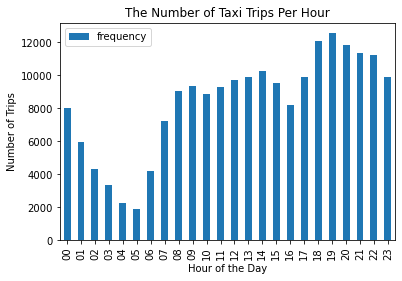

In [165]:
some_dataframe = get_data_for_taxi_trips()
plot_taxi_trips(some_dataframe)

### Visualization 2

_**TODO:** We aim to show the average distance traveled per month(regardless of the year) using combined statistics from Taxi and Uber. Also, we would include 90% confidence interval around the mean._


In [ ]:
query_avg_distance = """
    WITH hired_trips AS(
        SELECT 
            DATE(pickup_datetime) AS DAY, 
            distance
        FROM uber_trips
        
        UNION
        
        SELECT
            DATE(pickup_datetime) AS DAY, 
            distance
        FROM taxi_trips)
        
        SELECT strftime('%m', YEAR_MONTH) AS MONTH,
            AVG(monthdistance) AS avgdistance
        FROM
        (
        SELECT strftime('%Y-%m', DAY) AS YEAR_MONTH,
            SUM(distance) AS monthdistance
        FROM hired_trips
        GROUP BY YEAR_MONTH
        )
        GROUP BY MONTH       
    """

In [ ]:
# use a more descriptive name for your function
def plot_visual_n(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()

In [ ]:
def get_data_for_visual_n():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    raise NotImplemented()

In [ ]:
some_dataframe = get_data_for_visual_n()
plot_visual_n(some_dataframe)